In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd 'drive/MyDrive/Uni/UniPD/HumanDataProject/Code'

/content/drive/MyDrive/Uni/UniPD/HumanDataProject/Code


In [ ]:
import threading
import psutil
import random
import time
import subprocess
import sys
import seaborn as sns
import pandas as pd
import os
import numpy as np
from config import PREPROCESSING_PATH ,DATASET_SPLIT_PATH
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from scipy.io import wavfile
import matplotlib.pyplot as plt



from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix,accuracy_score

In [ ]:
!pip install tensorflow-io
!pip install psutil

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 MB 18.1 MB/s eta 0:00:00


In [ ]:
sys.path.append(PREPROCESSING_PATH)

In [ ]:


import preprocessing_tf
import evaluation

In [ ]:
random.seed(42)
tf.random.set_seed(42)

In [ ]:

print("Number of GPU:", len(tf.config.list_physical_devices('GPU')))
print("Version:", tf.__version__)

Number of GPU: 1
Version: 2.15.0


# Dataset Loading

To improve training efficiency, the dataset is pre-loaded into runtime, avoiding slow read speeds from the drive. It's already divided into train, validation, and test folders.

In [ ]:
%cd /content/drive/MyDrive/Uni/UniPD/HumanDataProject

/content/drive/MyDrive/Uni/UniPD/HumanDataProject


In [ ]:
!unzip project_data_split.zip -d /content/data

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  inflating: /content/data/project_data_split/validation/off/439c84f4_nohash_3.wav  
  inflating: /content/data/project_data_split/validation/off/44c201dd_nohash_0.wav  
  inflating: /content/data/project_data_split/validation/off/44c201dd_nohash_1.wav  
  inflating: /content/data/project_data_split/validation/off/45692b02_nohash_0.wav  
  inflating: /content/data/project_data_split/validation/off/45692b02_nohash_1.wav  
  inflating: /content/data/project_data_split/validation/off/45692b02_nohash_2.wav  
  inflating: /content/data/project_data_split/validation/off/45692b02_nohash_3.wav  
  inflating: /content/data/project_data_split/validation/off/471a0925_nohash_0.wav  
  inflating: /content/data/project_data_split/validation/off/471a0925_nohash_1.wav  
  inflating: /content/data/project_data_split/validation/off/471a0925_nohash_2.wav  
  inflating: /content/data/project_data_split/validation/off/471a0925_nohash_3.wav 

In [ ]:
#DATASET_SPLIT_PATH = "/content/data/project_data_split"

# Create train and validation dataset

Construct dataframes that includes the file paths and the corresponding spoken command (label) for each audio sample. The dataset comprises audio samples of 25 keywords: `backward`, `down`, `eight`, `five`, `follow`, `forward`, `four`, `go`, `learn`, `left`, `nine`, `no`, `off`, `on`, `one`, `right`, `seven`, `six`, `stop`, `three`, `two`, `up`, `visual`, `yes`, `zero`. Additionally, it contains 10 words `bed`,`bird`,`cat`, `dog`,`happy`,`house`,`marvin`,`sheila`,`tree`,`wow` that the model should not recognize as keywords.

To facilitate model training and evaluation, the labels are appropriately mapped: labels corresponding to the 25 keywords are retained in their original form, signifying that these are the commands the model is expected to recognize. Conversely, the labels for the 10 non-keyword words are mapped to a single class named "unknown". This approach consolidates these distinct non-keyword labels into a single category, simplifying the model's task by reducing the classification scope to the keywords and an "unknown" class for any non-keyword utterances.

In [ ]:
train_df = preprocessing_tf.get_file_list(os.path.join(DATASET_SPLIT_PATH,"train"))
val_df = preprocessing_tf.get_file_list(os.path.join(DATASET_SPLIT_PATH,"validation"))

In [ ]:
train_df.head()

,filepath,label,mapped_label
0,/content/data/project_data_split/train/one/2ac...,one,one
1,/content/data/project_data_split/train/one/9a7...,one,one
2,/content/data/project_data_split/train/one/813...,one,one
3,/content/data/project_data_split/train/one/ee1...,one,one
4,/content/data/project_data_split/train/one/eea...,one,one


In [ ]:
file_paths = tf.constant(train_df['filepath'].values)
labels = tf.constant(train_df['mapped_label'].values)

In [ ]:
# Create a StringLookup layer
#label_lookup = label_lookup = tf.keras.layers.StringLookup(num_oov_indices=0)
label_lookup = tf.keras.layers.StringLookup(num_oov_indices=0)
label_lookup.adapt(labels)
# Transform labels into numeric
numeric_labels = label_lookup(labels)

# Create a TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((file_paths, numeric_labels))

In [ ]:
file_paths_val = tf.constant(val_df['filepath'].values)
labels_val = tf.constant(val_df['mapped_label'].values)
numeric_labels_val = label_lookup(labels_val)
validation_dataset = tf.data.Dataset.from_tensor_slices((file_paths_val, numeric_labels_val))

# Preprocessing the Datasets

The training and validation datasets undergo preprocessing through our established pipeline. For the baseline model, the preprocessing involves only two steps: padding the data to ensure uniformity in size, which is essential for the model's input requirements, and converting the audio files into spectrograms.

In [ ]:
#With parameters
#train_spectrogram_ds = train_dataset.map(lambda fp, lbl: preprocessing_tf.preprocess_map_new(fp, lbl,resample=True,mfcc=True),
#                               num_parallel_calls=tf.data.AUTOTUNE)

train_spectrogram_ds = train_dataset.map(lambda fp, lbl: preprocessing_tf.preprocess_map_new(fp, lbl),
                               num_parallel_calls=tf.data.AUTOTUNE)
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)


val_spectrogram_ds = validation_dataset.map(lambda fp, lbl: preprocessing_tf.preprocess_map_new(fp, lbl),
                               num_parallel_calls=tf.data.AUTOTUNE)
val_spectrogram_ds= val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

Padding shape: (16000,)
Signal shape: (16000,)
Spectrogram shape: (124, 129, 1)
Padding shape: (16000,)
Signal shape: (16000,)
Spectrogram shape: (124, 129, 1)


In [ ]:
batch_size = 32
train_spectrogram_ds = train_spectrogram_ds.batch(batch_size)
val_spectrogram_ds = val_spectrogram_ds.batch(batch_size)

In [ ]:


input_shape =train_spectrogram_ds.element_spec[0].shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_lookup.get_vocabulary())
print('Number of labels:', num_labels)

Input shape: (124, 129, 1)
Number of labels: 26


# Model

The baseline model adopted for our analysis originates from the TensorFlow tutorial designed for a mini version of the speech dataset https://www.tensorflow.org/tutorials/audio/simple_audio. This model serves primarily as a benchmark for comparison purposes. Our objective is to demonstrate that subsequent models, which incorporate more intricate architectures or employ additional preprocessing steps, will surpass the performance of this baseline model.


We had intended to use the model developed by the dataset creator [Warden18] as our baseline. However we were not able to access this model. The model, according to the referenced paper, was available at the following URL: https://www.tensorflow.org/tutorials/audio_recognition. Unfortunately, as of February 8, 2024, this link is no longer accessible.

In [ ]:
# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

In [ ]:
model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0

In [ ]:

stop_event = threading.Event()
log_file_path = 'gpu_log_files/gpu_usage_baseline_model.txt'  # Specify your log file path
interval = 30  # Log every 1 second

In [ ]:
thread = threading.Thread(target=evaluation.log_gpu_usage, args=(log_file_path, stop_event, interval), daemon=True)
thread.start()

In [ ]:
EPOCHS = 10
start_time = time.time()
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)
end_time = time.time()  # Record the end time
cpu_usage_train = evaluation.get_system_ram_usage()
#cpu_usage_train = psutil.cpu_percent() #* 12.7
stop_event.set()
thread.join()
total_time_train = end_time - start_time
print(f"CPU Usage: {cpu_usage_train} GB")
print(f"Total training time: {total_time_train} seconds")

Epoch 1/10
2652/2652 [==============================] - 37s 11ms/step - loss: 1.4348 - accuracy: 0.5864 - val_loss: 3.4888 - val_accuracy: 0.3612
Epoch 2/10
2652/2652 [==============================] - 15s 6ms/step - loss: 0.8474 - accuracy: 0.7421 - val_loss: 2.4234 - val_accuracy: 0.4639
Epoch 3/10
2652/2652 [==============================] - 15s 6ms/step - loss: 0.6700 - accuracy: 0.7938 - val_loss: 2.3687 - val_accuracy: 0.4774
Epoch 4/10
2652/2652 [==============================] - 16s 6ms/step - loss: 0.5900 - accuracy: 0.8175 - val_loss: 2.1733 - val_accuracy: 0.4901
Epoch 5/10
2652/2652 [==============================] - 15s 6ms/step - loss: 0.5451 - accuracy: 0.8313 - val_loss: 1.9436 - val_accuracy: 0.5296
Epoch 6/10
2652/2652 [==============================] - 15s 6ms/step - loss: 0.5020 - accuracy: 0.8446 - val_loss: 1.6560 - val_accuracy: 0.5809
Epoch 7/10
2652/2652 [==============================] - 15s 6ms/step - loss: 0.4753 - accuracy: 0.8523 - val_loss: 2.1103 - val_a

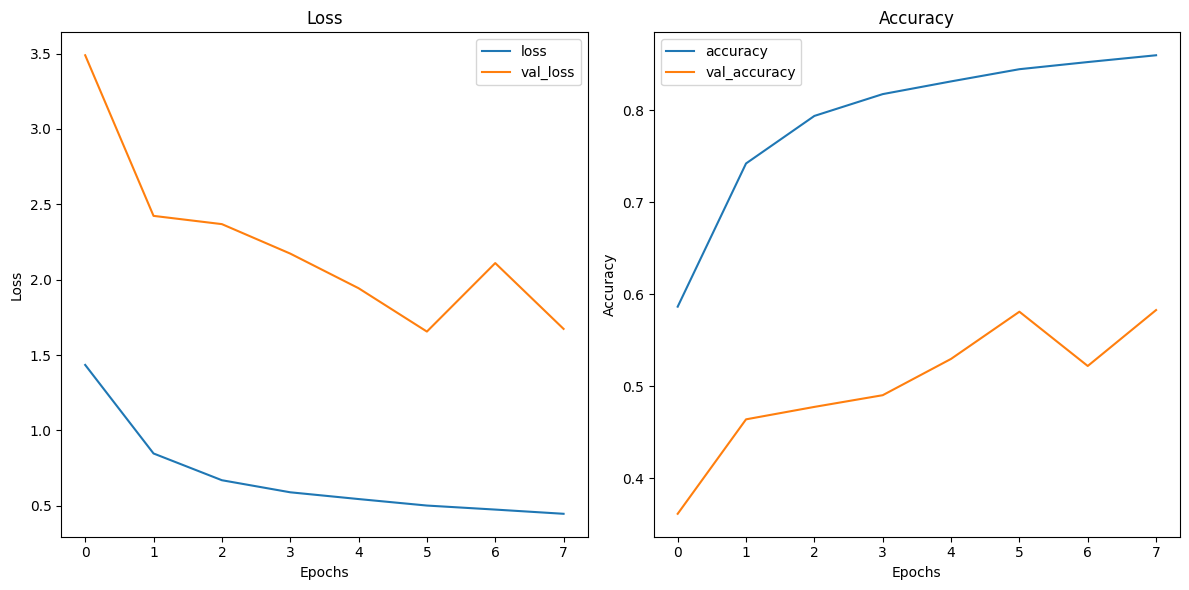

In [ ]:
evaluation.plot_fit_history(history, ['loss', 'val_loss'],['accuracy', 'val_accuracy'])

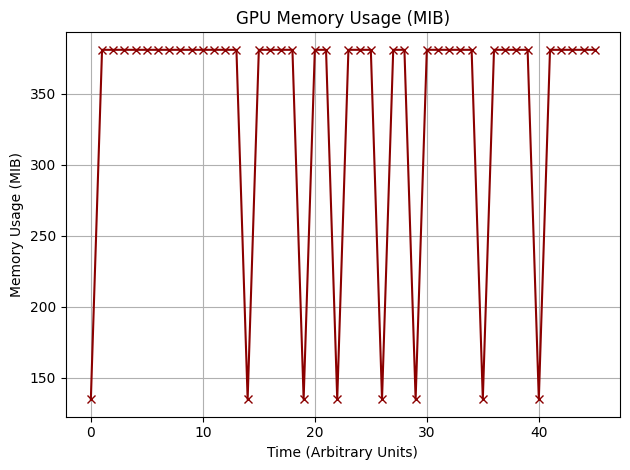

In [ ]:
df_gpu_train = evaluation.get_gpu_usage(log_file_path)

In [ ]:
#save model
model.save('Models/baseline', save_format='tf')

# Evaluation
The model's performance on our test dataset is assessed using the top-1 error rate, which is the same metric employed by the dataset's creator.

In [ ]:
test_df = preprocessing_tf.get_file_list(os.path.join(DATASET_SPLIT_PATH,"test"))
file_paths_test = tf.constant(test_df['filepath'].values)
labels_test = tf.constant(test_df['mapped_label'].values)
numeric_labels_test = label_lookup(labels_test)
test_dataset = tf.data.Dataset.from_tensor_slices((file_paths_test, numeric_labels_test))


In [ ]:
test_spectrogram_ds = test_dataset.map(lambda fp, lbl: preprocessing_tf.preprocess_map_new(fp, lbl, noise=True),
                               num_parallel_calls=tf.data.AUTOTUNE)

Padding shape: (16000,)
/content/data/project_data_split/_background_noise_/running_tap.wav
Noisy shape: (16000,)
Signal shape: (16000,)
Spectrogram shape: (124, 129, 1)


In [ ]:
batch_size = 32
test_spectrogram_ds = test_spectrogram_ds.batch(batch_size)

In [ ]:
stop_event = threading.Event()
log_file_path = 'gpu_log_files/gpu_usage_baseline_model_test.txt'
interval = 10

In [ ]:
thread = threading.Thread(target=evaluation.log_gpu_usage, args=(log_file_path, stop_event, interval), daemon=True)
thread.start()

In [ ]:
start_time = time.time()
predictions = model.predict(test_spectrogram_ds)
end_time = time.time()
#cpu_usage_test = psutil.cpu_percent()
cpu_usage_test = evaluation.get_system_ram_usage()
stop_event.set()
total_time_test = end_time - start_time
print(f"Total testing time: {total_time_test} seconds")

/content/drive/MyDrive/Uni/UniPD/HumanDataProject/Code/preprocessing_tf.py:39: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, data = wavfile.read(file_path)


 68/344 [====>.........................] - ETA: 40s

/content/drive/MyDrive/Uni/UniPD/HumanDataProject/Code/preprocessing_tf.py:39: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, data = wavfile.read(file_path)


134/344 [==========>...................] - ETA: 31s

/content/drive/MyDrive/Uni/UniPD/HumanDataProject/Code/preprocessing_tf.py:39: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, data = wavfile.read(file_path)


201/344 [================>.............] - ETA: 21s

/content/drive/MyDrive/Uni/UniPD/HumanDataProject/Code/preprocessing_tf.py:39: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, data = wavfile.read(file_path)


265/344 [======================>.......] - ETA: 11s

/content/drive/MyDrive/Uni/UniPD/HumanDataProject/Code/preprocessing_tf.py:39: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, data = wavfile.read(file_path)


333/344 [============================>.] - ETA: 1s

/content/drive/MyDrive/Uni/UniPD/HumanDataProject/Code/preprocessing_tf.py:39: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, data = wavfile.read(file_path)


344/344 [==============================] - 53s 152ms/step
Total testing time: 53.29848384857178 seconds


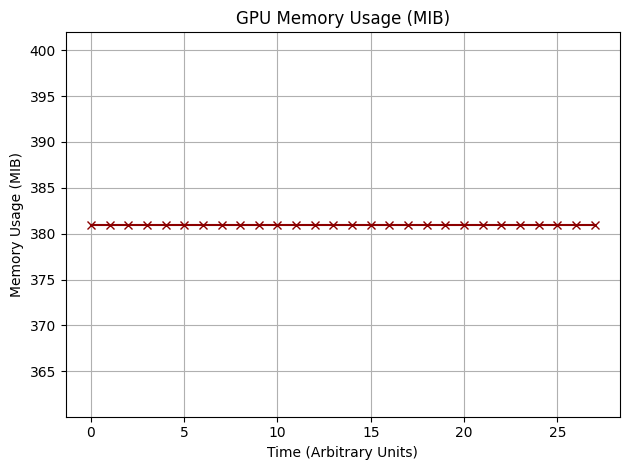

In [ ]:
df_gpu_test = evaluation.get_gpu_usage(log_file_path)

In [ ]:
true_labels = np.concatenate([y for x, y in test_spectrogram_ds], axis=0)
metrics_df = evaluation.get_error_metrics("Baseline Model", true_labels, predictions)
metrics_df.head()

/content/drive/MyDrive/Uni/UniPD/HumanDataProject/Code/preprocessing_tf.py:39: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, data = wavfile.read(file_path)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Model Name,Precision,Recall,F1 Score,Accuracy,Cross-Entropy Loss
0,Baseline Model,0.548313,0.266889,0.241465,0.338119,2.509869


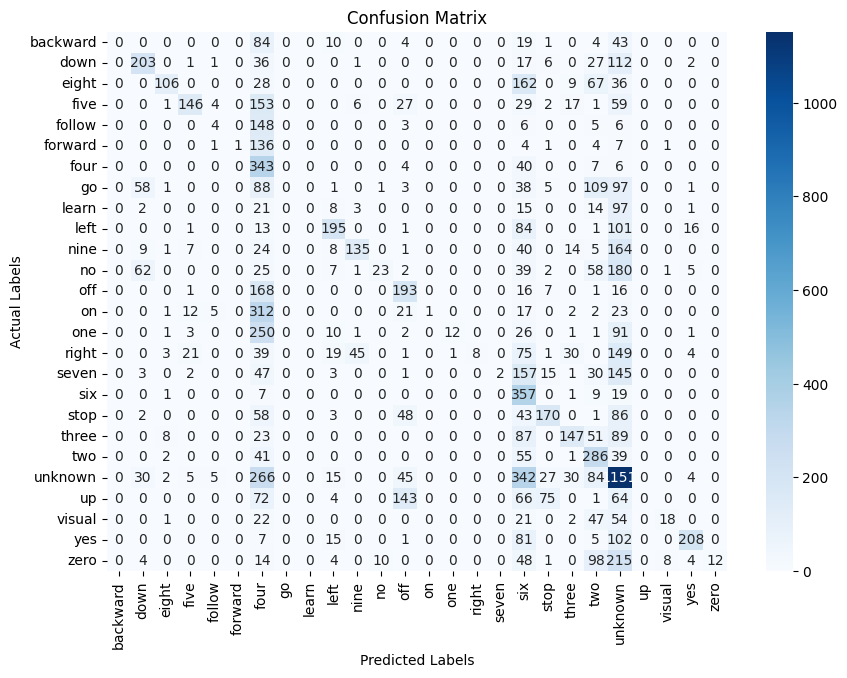

In [ ]:
evaluation.plot_confusion_matrix(true_labels,predictions,label_lookup)

# Summary

In [ ]:
mean_train = df_gpu_train['Memory Usage (MiB)'].mean()
mean_test = df_gpu_test['Memory Usage (MiB)'].mean()
max_train = df_gpu_train['Memory Usage (MiB)'].max()
max_test = df_gpu_test['Memory Usage (MiB)'].max()
total_params = model.count_params()

In [ ]:
print(f"Training time: {total_time_train:.3f} seconds")
print(f"Average GPU usage train: {mean_train:.3f} MiB")
print(f"Maximum GPU usage train: {max_train:.3f} MiB")
print(f"CPU usage train: {cpu_usage_train:.3f} GB")

print(f"Testing time: {total_time_test:.3f} seconds")
print(f"Average GPU usage test: {mean_test:.3f} MiB")
print(f"Maximum GPU usage test: {max_test:.3f} MiB")
print(f"CPU usage test: {cpu_usage_test:.3f} GB")

print(f"Number of parameters: {total_params}")

#Number of model parameters

metrics_df.head()

Training time: 164.835 seconds
Average GPU usage train: 338.217 MiB
Maximum GPU usage train: 381.000 MiB
CPU usage train: 11.402 GB
Testing time: 53.298 seconds
Average GPU usage test: 381.000 MiB
Maximum GPU usage test: 381.000 MiB
CPU usage test: 11.330 GB
Number of parameters: 1627933


,Model Name,Precision,Recall,F1 Score,Accuracy,Cross-Entropy Loss
0,Baseline Model,0.548313,0.266889,0.241465,0.338119,2.509869


Overall, the Baseline Model demonstrates an okay precision but suffers significantly in terms of recall, leading to a low F1 score. This discrepancy suggests that while the model can be quite confident in the instances it chooses to positively label, it misses many actual positive instances. The accuracy being below 50% along with a high cross-entropy loss indicates that there is substantial room for improvement, especially in terms of the model's ability to generalize (as with 0.8597 we have a good training accuracy) and correctly identify positive instances across the dataset.


The GPU memory requirements for model training and testing are modest, at only 381 MiB, which is advantageous since devices typically used for keyword spotting often have limited memory capacity. However, the system RAM usage is notably high at 11.8 GB. This could present challenges for keyword spotting devices, as they may not have sufficient memory resources to support such demands effectively.

#References

**[Warden18]**

Pete Warden, Speech Commands: A Dataset for Limited-Vocabulary Speech Recognition, arXiv:1804.03209, April 2018.